Let's load and pre-process data

In [53]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('punkt')
reddit = pd.read_json("../data/reddit_comments.json")
twitter = pd.read_csv("../data/twitter.csv")
dfs = {"Reddit": reddit, "Twitter": twitter}

def overview(dfs):
    for name, df in dfs.items():
        print("\n")
        print(f"{name} description")
        print(df.info())
        print("\n")
        print(f"{name} example")
        print(df.head(5))

overview(dfs)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!




Reddit description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18870 entries, 0 to 18869
Data columns (total 68 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _replies                         18870 non-null  object 
 1   id                               18870 non-null  object 
 2   total_awards_received            18870 non-null  int64  
 3   approved_at_utc                  0 non-null      float64
 4   comment_type                     0 non-null      float64
 5   edited                           18870 non-null  int64  
 6   mod_reason_by                    0 non-null      float64
 7   banned_by                        0 non-null      float64
 8   author_flair_type                14966 non-null  object 
 9   removal_reason                   0 non-null      float64
 10  link_id                          18870 non-null  object 
 11  author_flair_template_id         857 non-null    object 
 1

In [54]:
def standardize_datasets(dfs):
    dfs["Twitter"] = dfs["Twitter"][["tweet", "class"]]
    dfs["Twitter"] = dfs["Twitter"].rename(columns={"tweet": "text", "class": "label"})
    # 0 indicates hate speech, 2 indicates nothing. we need to reencode to 0, 1. (0=no hate speech, 1=hate speech).
    dfs["Twitter"]["label"] = dfs["Twitter"]["label"].replace({0: 1, 2: 0})
    dfs["Reddit"] = dfs["Reddit"][["body", "is_hate"]]
    dfs["Reddit"] = dfs["Reddit"].rename(columns={"body": "text", "is_hate": "label"})

standardize_datasets(dfs)
overview(dfs)




Reddit description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18870 entries, 0 to 18869
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    18870 non-null  object 
 1   label   18860 non-null  float64
dtypes: float64(1), object(1)
memory usage: 295.0+ KB
None


Reddit example
                                                text  label
0  A subsection of retarded Hungarians? Ohh boy. ...    1.0
1  Hiii. Just got off work. 444 is mainly the typ...    0.0
2  wow i guess soyboys are the same in every country    0.0
3  Owen Benjamin's soyboy song goes for every cou...    0.0
4  wouldn't the defenders or whatever they are as...    1.0


Twitter description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    24783 non-null  object
 1   label   24783 non-null  int64 
dtypes: int64

Let's check for missing values

In [64]:
def check_for_missing_values(dfs):
    for name, df in dfs.items():
        print(f"{name}")
        print(df.isnull().sum())

check_for_missing_values(dfs)

Reddit
text              0
label            10
num_words         0
num_sentences     0
source            0
dtype: int64
Twitter
text             0
label            0
num_words        0
num_sentences    0
source           0
dtype: int64


let's drop missings

In [66]:
def drop_missings(dfs):
    for name, df in dfs.items():
        df.dropna(inplace=True)

drop_missings(dfs)
check_for_missing_values(dfs)

Reddit
text             0
label            0
num_words        0
num_sentences    0
source           0
dtype: int64
Twitter
text             0
label            0
num_words        0
num_sentences    0
source           0
dtype: int64


Let's do some visualization

In [67]:
# Functions to calculate number of words and sentences
def count_words(text):
    words = nltk.word_tokenize(text)
    return len(words)

def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

def process_df(df):
    # Apply functions to DataFrame
    df['num_words'] = df['text'].apply(count_words)
    df['num_sentences'] = df['text'].apply(count_sentences)

for name, df in dfs.items():
    process_df(df)

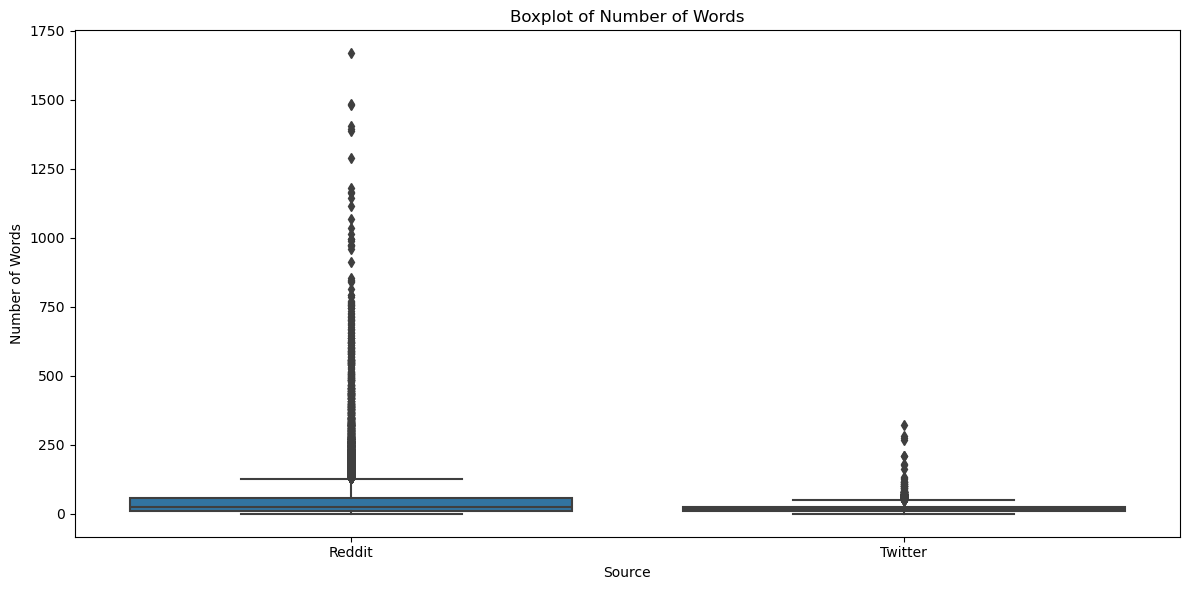

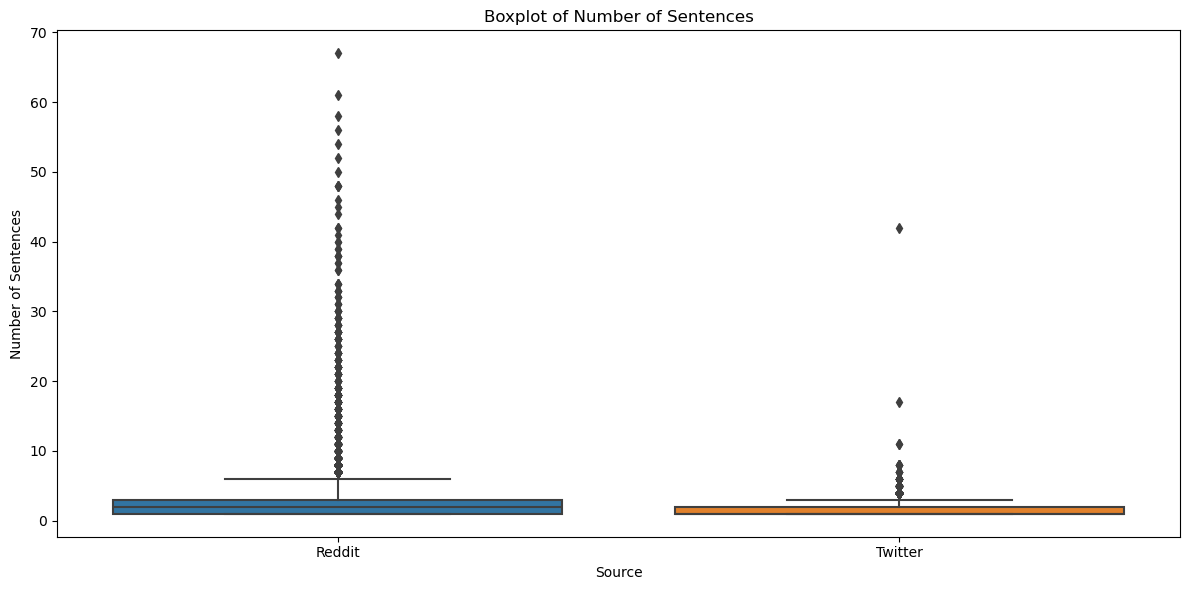

In [68]:
def plot_num_words(dfs):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df['source'] = name
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_words', data=combined_df)
    plt.title('Boxplot of Number of Words')
    plt.xlabel('Source')
    plt.ylabel('Number of Words')
    plt.tight_layout()
    plt.show()

def plot_num_sentences(dfs):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df['source'] = name
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_sentences', data=combined_df)
    plt.title('Boxplot of Number of Sentences')
    plt.xlabel('Source')
    plt.ylabel('Number of Sentences')
    plt.tight_layout()
    plt.show()

plot_num_words(dfs)
plot_num_sentences(dfs)

Let's plot with an upper boundary on outliers, for better visibility

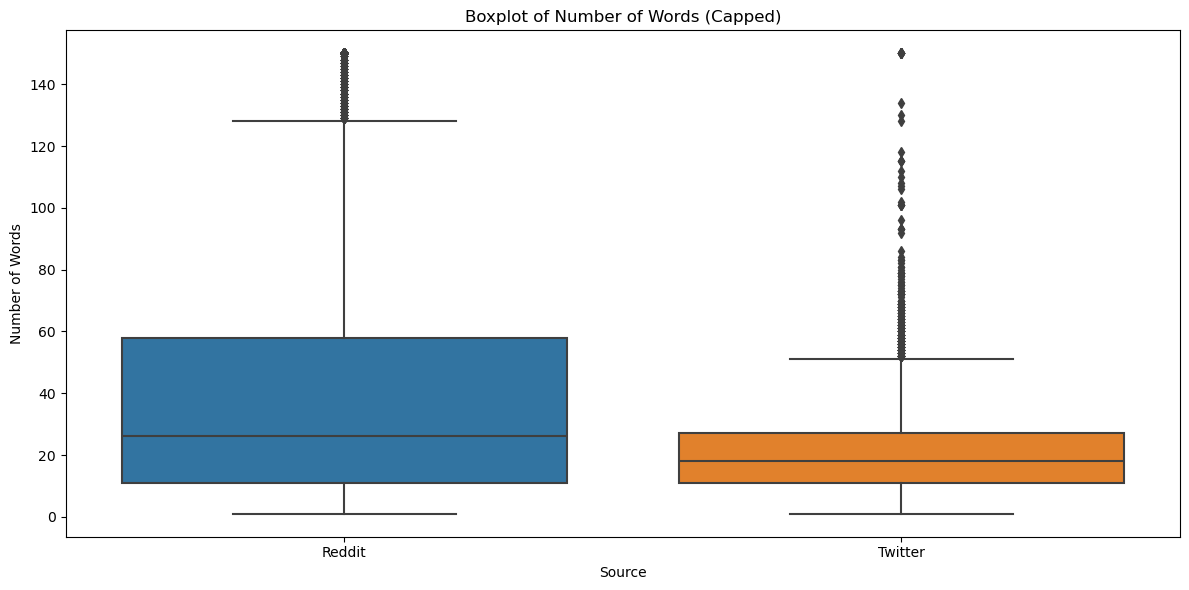

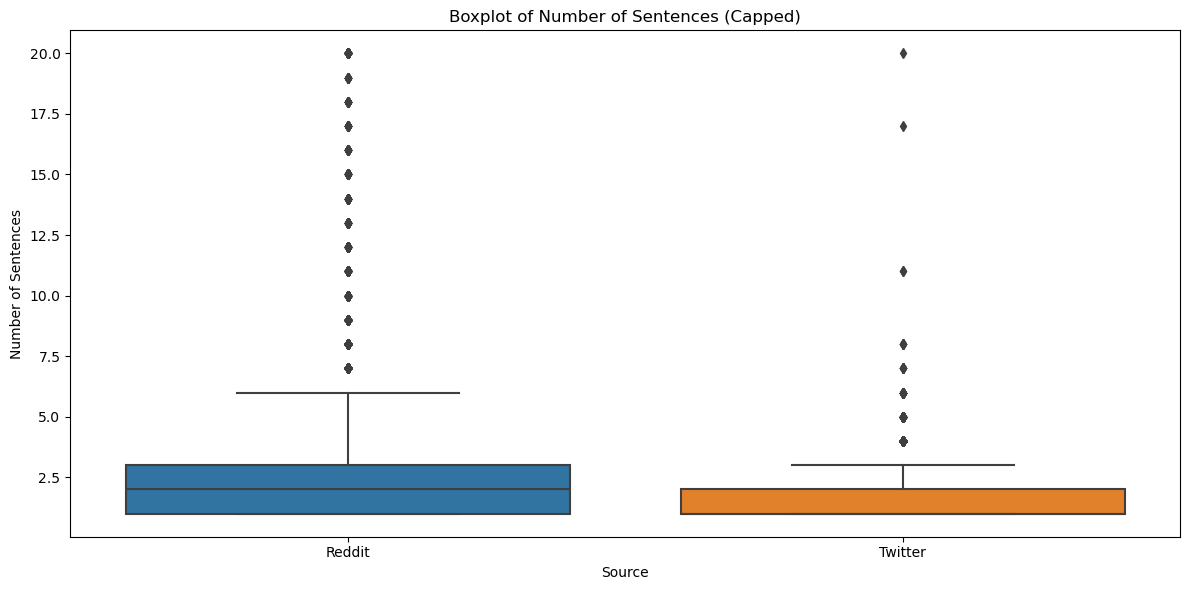

In [71]:
def cap_outliers(df, column, upper_bound):
    df_copy = df.copy()
    df_copy[column] = df_copy[column].apply(lambda x: min(x, upper_bound))
    return df_copy

def plot_num_words(dfs, upper_bound):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df_capped = cap_outliers(df, 'num_words', upper_bound)
        df_capped['source'] = name
        combined_df = pd.concat([combined_df, df_capped], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_words', data=combined_df)
    plt.title('Boxplot of Number of Words (Capped)')
    plt.xlabel('Source')
    plt.ylabel('Number of Words')
    plt.tight_layout()
    plt.show()

def plot_num_sentences(dfs, upper_bound):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df_capped = cap_outliers(df, 'num_sentences', upper_bound)
        df_capped['source'] = name
        combined_df = pd.concat([combined_df, df_capped], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_sentences', data=combined_df)
    plt.title('Boxplot of Number of Sentences (Capped)')
    plt.xlabel('Source')
    plt.ylabel('Number of Sentences')
    plt.tight_layout()
    plt.show()

plot_num_words(dfs, 150)
plot_num_sentences(dfs, 20)

Now let's examine labels

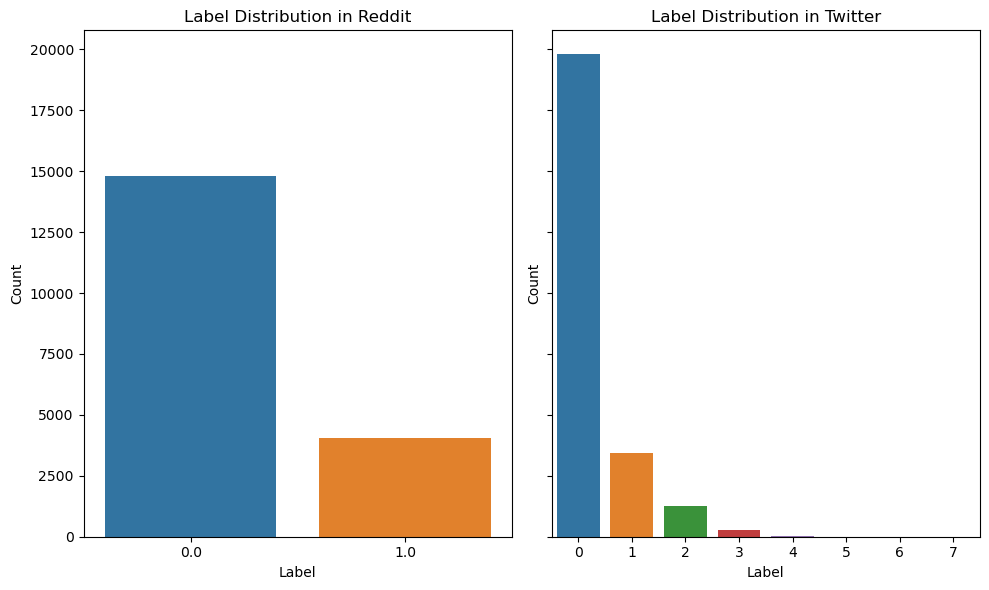

In [72]:
def plot_label_distribution(dfs):
    # Prepare the figure for subplots
    num_dfs = len(dfs)
    fig, axes = plt.subplots(1, num_dfs, figsize=(5 * num_dfs, 6), sharey=True)
    
    if num_dfs == 1:
        axes = [axes]  # Make sure axes is iterable if there's only one DataFrame

    # Plot each DataFrame
    for ax, (name, df) in zip(axes, dfs.items()):
        sns.countplot(x='label', data=df, ax=ax)
        ax.set_title(f'Label Distribution in {name}')
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_label_distribution(dfs)